# Pulse Shaping 

The goal of this notebook is to mess around with some common pulse shaping techniques. I want to simulate and compare the following pulse-shaping/windowing options.

1. Rectangular 
2. Gaussian 
3. Sinc 
4. Hanning Window
5. Raised Cosine

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Generate Data Symbols

The input into a pulse shaping filter is often a set of data symbols. The symbols are simply a set of numbers where each number represents one symbol. It is very common to use complex symbols to simulate IQ based communications systems. A set of symbols can be mathametically describes as:

$$
s_i = \{s_1, s_2, ..., s_{K-1}\}
$$

where each $s_i$ is a complex number denotes as $s_i = s_{Ii} + js_{Qi}$. The set of all $K$ symbols is reffered to as the symbol alphabet. 

If you are tranmitting complex IQ symbols then for a set of $K$ symbols, each symbol ${s_i}$ carries $2*log_2\left({K}\right)$. 

In the case of nulling the Q/imaginary component of the symbols (see BPSK for example) each symbol tranmits $log_2\left({k}\right)$ bits, or half as much as if both components are utalized. 

The code below is an easy way to generate random symbols from an arbitrary alphabet. It utalized the `np.random.choice()` function. 

In [3]:
n_symbols = 8
symbol_alphabet = np.array([-1, 1])
data_symbols = np.random.choice(symbol_alphabet, n_symbols) 

# Step 2: Generate A Pulse Waveform

In [4]:
def pulse_shape(data_symbols:np.array, pulse_signal:np.array, flatten=False)->np.array:
    """ Generate pulse shaped data array.
       
        Positional Arguments:
            data_symbols: set of data symbols to be shaped.
            pulse_signal: The pulse waveform that does the shaping.
            flatten: T/F, if true then the returned data will be a row vector with shape (1, n_sym*sps).
                          if false then the returned data will be a matrix where each row is a pulse-shaped symbol. dim -> (n_sym, sps)
            
    """
    n_sym = len(data_symbols)
    sps = len(pulse_signal)
    data = np.multiply(data_symbols.reshape(n_sym, 1), pulse_signal.reshape(1, sps))
    if flatten:
        return data.reshape(1, int(n_sym*sps))
    else:
        return data 

In [5]:
bpsk_alphabet = np.array([1, -1])
qpsk_alphabet = np.array([1+1j, 1-1j, -1+1j, -1-1j])
symbol_alphabet = bpsk_alphabet
n_symbols = 1
data_symbols = np.random.choice(symbol_alphabet, n_symbols)
#generate a pulse
T_sym = 1 #seconds
span = 1 #number of symbol periods the pulse spans
sps = 200 #number of samples per symbol
fs = sps/T_sym
t = (1/fs)*np.arange(0, int(n_symbols*sps))

## Rect Pulse Shaping

In [39]:
def pulse_rect(sps, t_sym, rect_width=-1):
    if rect_width==-1 or rect_width==t_sym:
        return np.ones(sps)
    n_ones = int((rect_width/t_sym)*sps)
    n_zeros = int((sps-n_ones)/2)
    #TODO: make this always return a signal with size=sps
    assert sps == n_ones + n_zeros + n_zeros
    return np.hstack((np.zeros(n_zeros), np.ones(n_ones), np.zeros(n_zeros)))

(1, 200)


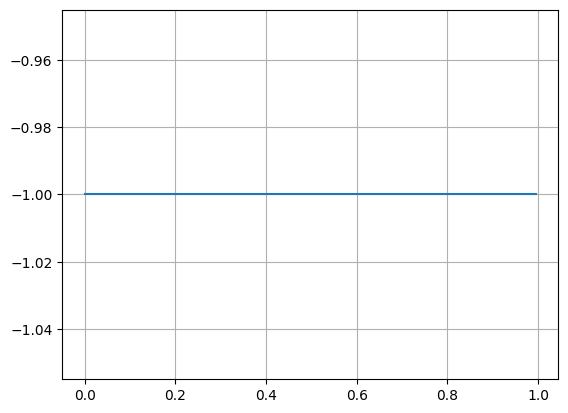

In [43]:
rect_width = T_sym/1
rect_pulse = pulse_rect(sps, T_sym, rect_width)
data = pulse_shape(data_symbols, rect_pulse, False)
print(data.shape)

plt.plot(t, data.reshape(data.size,))
plt.grid()

## Sinc Pulse Shaping

In [44]:
def pulse_sinc(sps, t_sym, lobe_width):
    N = sps
    t = (t_sym/sps)*np.arange(-N/2, N/2)
    return np.sinc(2*t/lobe_width)

(1, 200)


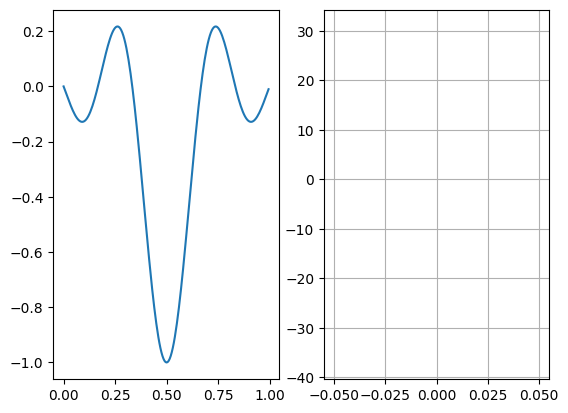

In [45]:
sinc_width = T_sym/3
sinc_pulse = pulse_sinc(sps, T_sym, sinc_width)
data = pulse_shape(data_symbols, sinc_pulse, False)
print(data.shape)

data_f = np.fft.fftshift(np.fft.fft(data))

plt.subplot(121)
plt.plot(t, data.reshape(data.size,))
plt.subplot(122)
plt.plot(data_f)
plt.grid()

## Guassian Pulse Shaping

In [66]:
def pulse_guass(sps, t_sym, alpha):
    N = span*sps
    t = (t_sym/sps)*np.arange(-N/2, N/2+1)
    print(len(t))
    return np.sqrt(alpha/np.pi) * np.exp(-1*alpha*np.power(t,2))

## Raised Cosine Pulse Shaping

In [67]:
def pulse_rcos(span, sps, t_sym, beta, shape='sqrt'):
    assert 0<=beta<=1, 'beta should be beween 0 and 1.'
    N = span*sps #number of samples in the filter
    T = t_sym #assumed symbol period of 1
    t = (t_sym/sps)*np.arange(-N/2, N/2+1)
    if beta==0:
        h = np.sinc(t)
        if (shape=='sqrt'): h = np.sqrt(h)
        return h
    numerator = np.cos(np.pi*beta*t)*np.sinc(t)
    denominator = 1-np.power(2*beta*t,2) 
    h = numerator/denominator
    h[len(h)//2]=1
    for i,val in enumerate(t):
        if np.absolute(val) == 1/(2*beta):
            h[i] = (np.pi/4) * np.sinc(1/(2*beta)) 
    if (shape=='sqrt'): h = np.sqrt(np.absolute(h))
    return h

In [36]:
#span = 8 
#sps = 64 
#plt.figure(1)
#for beta in [0,0.25,0.5,1]:
#    plt.subplot(121)   
#    h = pulse_rcos(beta, span, sps, 'none')
#    plt.plot(h, label = 'beta = {}'.format(beta))
#    plt.subplot(122)
#    h = pulse_rcos(beta, span, sps, 'sqrt')
#    plt.plot(h, label = 'beta = {}'.format(beta))
#plt.subplot(121)
#plt.title('Raised Cosine Pulse')
#plt.xlabel('Samples')
#plt.ylabel('Amplitude')
#plt.legend()
#plt.subplot(122)
#plt.title('Root-Raised Cosine Pulse')
#plt.xlabel('Samples')
#plt.ylabel('Amplitude')
#plt.legend()
#plt.tight_layout()

## Pulse Shaping Effect On Frequency Response

## Final Compairison 